In [54]:
# -*- coding: utf-8 -*-
# Importations
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import psycopg2 as pg
import scipy.special
import pandas_profiling
from pandas.plotting import lag_plot

In [4]:
fct_haemo = pd.read_csv('../data/model/fct_haemodynamic.csv',index_col=0)
fct_haemo['id_patient'] = fct_haemo['id_patient'].astype(int)
fct_haemo['dc'] = fct_haemo['dc'].astype(float)
fct_haemo['fc'] = fct_haemo['fc'].astype(float)
fct_haemo['papdia'] = fct_haemo['papdia'].astype(float)
fct_haemo['papmoy'] = fct_haemo['papmoy'].astype(float)
fct_haemo['papsys'] = fct_haemo['papsys'].astype(float)
fct_haemo['pasd'] = fct_haemo['pasd'].astype(float)
fct_haemo['pasm'] = fct_haemo['pasm'].astype(float)
fct_haemo['pass'] = fct_haemo['pass'].astype(float)
fct_haemo['pnid'] = fct_haemo['pnid'].astype(float)
fct_haemo['pnim'] = fct_haemo['pnim'].astype(float)
fct_haemo['pnis'] = fct_haemo['pnis'].astype(float)

In [5]:
pandas_profiling.ProfileReport(fct_haemo).to_file(outputfile="fct_haemo_profiling.html")

In [6]:
dim_patient = pd.read_csv('../data/dim_patient.csv')

In [7]:
df = pd.merge(fct_haemo, dim_patient[['id_patient','date_transplantation']], on='id_patient')
df['timestamp'] = df['date_transplantation'] + '-' +df['time']
df = df[df['time'] != '0']
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
#https://machinelearningmastery.com/time-series-data-visualization-with-python/

# Plotting time series for one patient/one variable

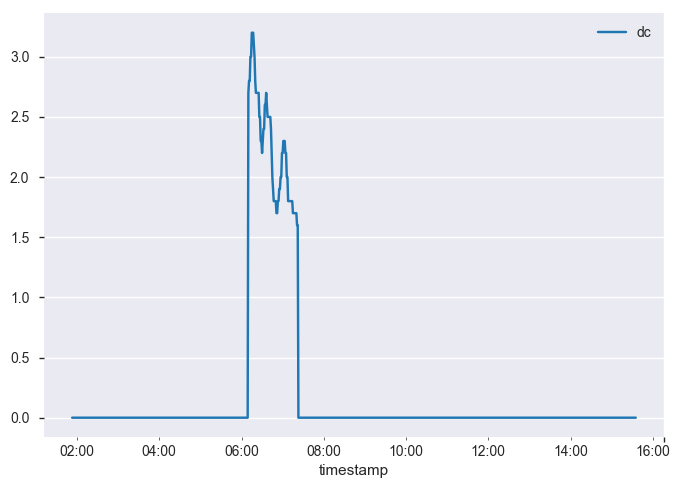

In [31]:
df[df['id_patient'] == 301].plot(y='dc',x='timestamp')

# Scatter plot of a time serie to investigate its stationarity

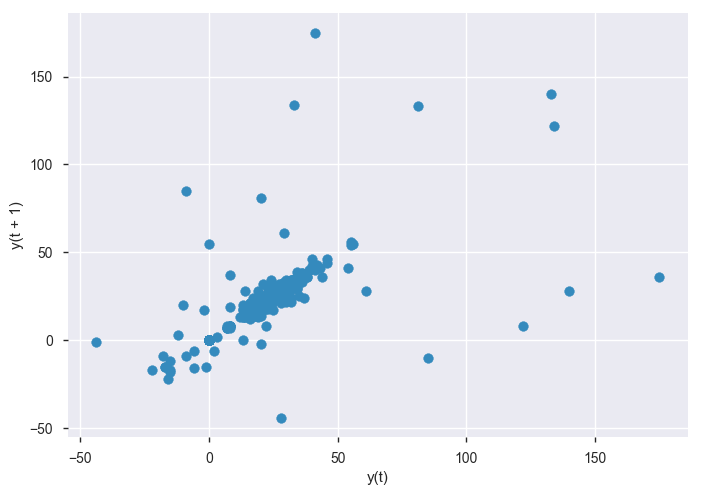

In [65]:
pat = df[df['id_patient'] == 301]
pat = pat.drop(columns=['time','date_transplantation'])
pat['papmoy_shift'] = pat['papmoy'].shift(1)
lag_plot(pat['papmoy'])

# Make a time series stationary with x_t = log(x_t) - log(x_(t-1))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


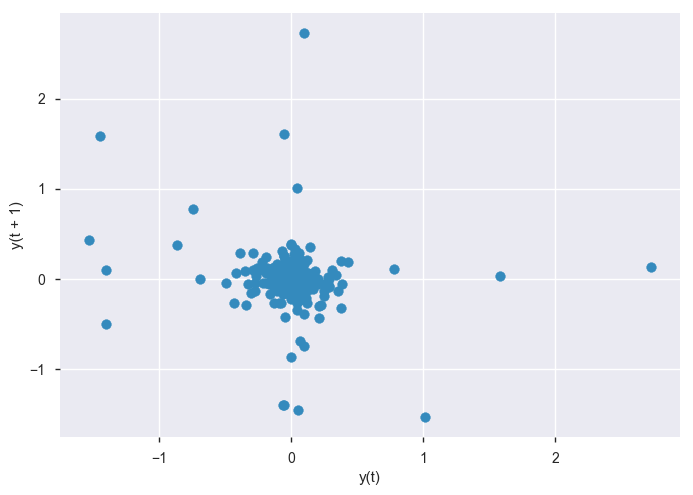

In [67]:
lag_plot(np.log(pat['papmoy_shift']) - np.log(pat['papmoy']))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


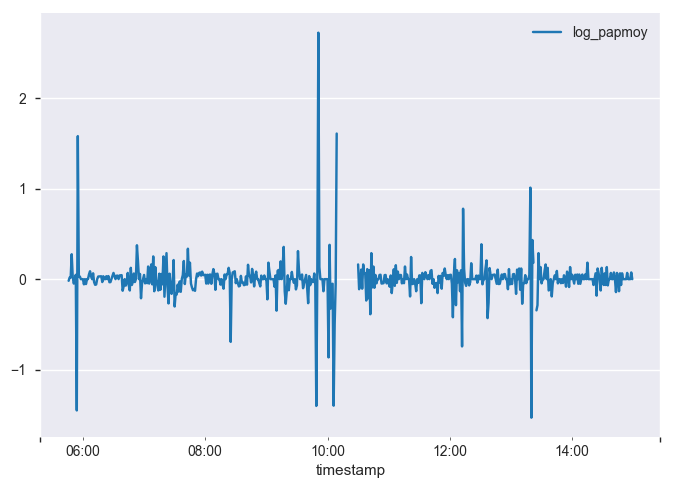

In [68]:
pat['log_papmoy'] = np.log(pat['papmoy_shift']) - np.log(pat['papmoy'])    
pat.plot(y='log_papmoy',x='timestamp')

In [69]:
pat

,dc,fc,papdia,papmoy,papsys,pasd,pasm,pass,pnid,pnim,pnis,id_patient,timestamp,papmoy_shift,log_papmoy
20402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,2016-11-21 01:53:00,NaN,NaN
20403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,2016-11-21 01:54:00,0.0,NaN
20404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,2016-11-21 01:55:00,0.0,NaN
20405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,2016-11-21 01:56:00,0.0,NaN
20406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,2016-11-21 01:57:00,0.0,NaN
20407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,2016-11-21 01:58:00,0.0,NaN
20408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,2016-11-21 01:59:00,0.0,NaN
20409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,2016-11-21 02:00:00,0.0,NaN
20410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,2016-11-21 02:01:00,0.0,NaN
20411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,2016-11-21 02:02:00,0.0,NaN


In [41]:
df.id_patient.unique()

array([381, 384, 372, 377, 370, 389, 388, 383, 373, 375, 382, 368, 371,
       390, 369, 386, 379, 376, 362, 378, 391, 367, 387, 363, 364, 380,
       366, 392, 329, 323, 316, 301, 326, 311, 330, 319, 328, 314, 312,
       320, 327, 305, 325, 302, 315, 300, 309, 322, 318, 304, 308, 156,
       158, 164, 151, 163, 170, 155, 150, 171, 275, 175, 166, 172, 152,
       159, 168, 154, 153, 160, 167, 157, 161, 174, 219, 210, 232, 217,
       226, 211, 215, 223, 207, 220, 225, 218, 208, 209, 216, 224, 221,
       222, 206, 233, 213, 214, 229, 230, 227, 236, 234, 235, 231, 228,
       349, 351, 333, 354, 347, 357, 338, 346, 358, 109, 344, 359, 361,
       360, 334, 355, 342, 343, 335, 337, 336, 331, 352, 340, 356, 393,
       407, 404, 398, 400, 399, 403, 411, 410, 394, 405, 401, 397, 395,
       408, 409, 406, 396, 259, 239, 272, 267, 248, 265, 251, 245, 270,
       249, 247, 252, 263, 264, 237, 250, 269, 257, 238, 240, 246, 256,
       255, 241, 276, 271, 268, 273, 260, 243, 253, 258, 277, 24